# 🎯 Tüketici Davranışı ve E-Ticaret: Satın Alma Kararını Hangi Faktörler Etkiliyor?

---

❗️ **Uyarı:** Bu çalışma yalnızca veri analizi eğitimi amacıyla yapılmıştır.  
Herhangi bir ticari kuruluşla bağlantısı yoktur.  
Ticari bir amaç güdülmemektedir.

---

## 🔍 Proje Amacı

Bu projede, bir e-ticaret web sitesine ait kullanıcı oturum verileri analiz edilerek,
ziyaretçilerin satın alma kararlarını etkileyen faktörler keşfedilecektir.  
Amaç, satın alma (Revenue) ile ilişkili davranışsal ve teknik değişkenleri analiz ederek,
kullanıcı eğilimlerini anlamaktır.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

# Veri Kümesi Tanıtımı

- Veri Kaynağı: [Kaggle - Online Shoppers Intention Dataset](https://github.com/rruss2/predict_e-com_cust_behavior.git)

- Satır sayısı: 12.330

- Hedef değişken: Revenue (Satın alma gerçekleşti mi?)

- Veri türleri: Sayısal, kategorik ve boolean

In [4]:
from google.colab import files
files.upload()

df = pd.read_csv("online_shoppers_intention.csv")
print("Veri kümesi boyutu:", df.shape)
df.head()

Saving online_shoppers_intention.csv to online_shoppers_intention (2).csv
✅ Veri kümesi boyutu: (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Veri Yapısının İncelenmesi

In [5]:
df.info()
df.describe()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,0
Administrative,int64
Administrative_Duration,float64
Informational,int64
Informational_Duration,float64
ProductRelated,int64
ProductRelated_Duration,float64
BounceRates,float64
ExitRates,float64
PageValues,float64
SpecialDay,float64


In [15]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Sayısal Sütunlar:", list(num_cols))

cat_cols = df.select_dtypes(include=['object', 'bool']).columns
print("Kategorik Sütunlar:", list(cat_cols))

Sayısal Sütunlar: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Revenue_Int']
Kategorik Sütunlar: ['Month', 'VisitorType', 'Weekend', 'Revenue']


| Değişken Adı              | Türkçesi / Açıklama                                             |
| ------------------------- | --------------------------------------------------------------- |
| `Administrative`          | Yönetimsel sayfa sayısı (hakkımızda, iade şartları vb.)         |
| `Administrative_Duration` | Bu sayfalarda geçirilen toplam süre                             |
| `Informational`           | Bilgilendirme sayfa sayısı (SSS, yardım vb.)                    |
| `Informational_Duration`  | Bilgilendirme sayfalarında geçirilen süre                       |
| `ProductRelated`          | Ürün sayfa sayısı                                               |
| `ProductRelated_Duration` | Ürün sayfalarında geçirilen toplam süre                         |
| `BounceRates`             | Hemen çıkma oranı                                               |
| `ExitRates`               | Sayfadan çıkış oranı                                            |
| `PageValues`              | Sayfa değeri – sistemin o sayfaya atadığı tahmini parasal değer |
| `SpecialDay`              | Özel gün yakınlığı (0: uzak, 1: çok yakın)                      |
| `Month`                   | Ay (kategorik)                                                  |
| `VisitorType`             | Ziyaretçi türü (Yeni, Geri Dönen vs.)                           |
| `Weekend`                 | Ziyaret hafta sonunda mı gerçekleşti?                           |
| `OperatingSystems`        | Kullanıcının işletim sistemi (kodlanmış)                        |
| `Browser`                 | Tarayıcı tipi                                                   |
| `Region`                  | Bölge kodu                                                      |
| `TrafficType`             | Trafik kaynağı (organik, reklam, doğrudan vb.)                  |


# 🔍 Keşifsel Veri Analizi (EDA)

📌 1. Hedef Değişkenin Dağılımı

>- Revenue sütunu, bir kullanıcının ziyaretinin satın alma ile sonuçlanıp sonuçlanmadığını gösterir.
>- True = Satın alma gerçekleşmiş
>False = Satın alma gerçekleşmemiş
>

📌 2. Sayısal Değişkenlerin Satın Alma ile İlişkisi

>- Sayısal sütunlar üzerinden, satın alma yapanlar ve yapmayanların ortalamaları karşılaştırılır.
>
>- PageValues: Sayfanın gelir değeri (yüksekse satın alma olasılığı artabilir)
>
>- BounceRates: Kullanıcının hemen çıkma oranı
>
>- ProductRelated_Duration: Ürün sayfalarında geçirilen süre
>- Soru: Satın alma yapan kullanıcılar bu değişkenlerde farklılık gösteriyor mu?

📌 3. Kategorik Değişkenlerin Satın Alma ile İlişkisi

>- Belirli kategorilere göre (örneğin ay, ziyaretçi türü, hafta sonu) satın alma oranları analiz edilir.
>
>- Month: Satın alma hangi aylarda daha fazla gerçekleşiyor?
>
>- VisitorType: Yeni kullanıcılar mı, tekrar gelenler mi daha çok satın alıyor?
>
>- Weekend: Hafta sonu yapılan ziyaretlerde satın alma oranı nasıl değişiyor?



### Hedef Değişkenin Dağılımı

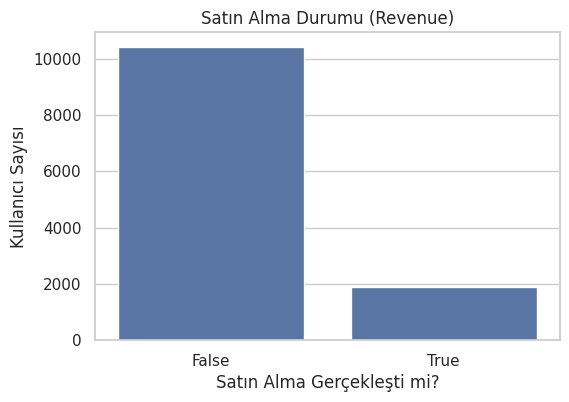

🔎 Revenue dağılımı (yüzde):
Revenue
False    84.53
True     15.47
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='Revenue', data=df)
plt.title("Satın Alma Durumu (Revenue)")
plt.xlabel("Satın Alma Gerçekleşti mi?")
plt.ylabel("Kullanıcı Sayısı")
plt.show()

revenue_percent = df['Revenue'].value_counts(normalize=True) * 100
print("🔎 Revenue dağılımı (yüzde):")
print(revenue_percent.round(2))

📊 Gözlem:

>- False (Satın alma yok): %84.53
>
>- True (Satın alma var): %15.47

### Sayısal Değişkenlerin Satın Alma ile İlişkisi

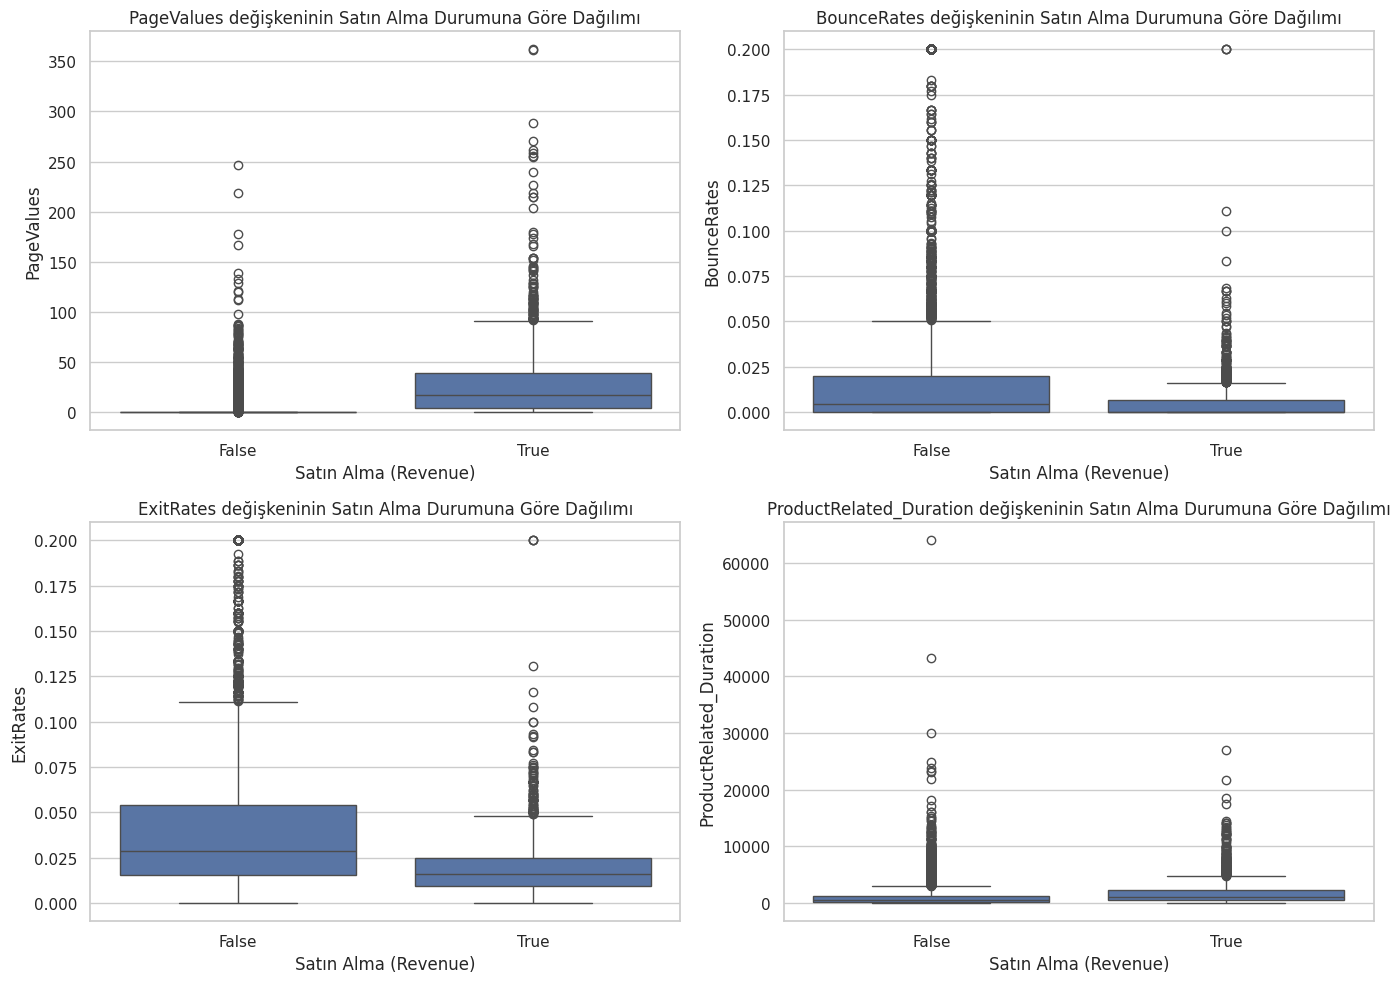

In [7]:
sns.set(style="whitegrid")

num_features = ['PageValues', 'BounceRates', 'ExitRates', 'ProductRelated_Duration']

plt.figure(figsize=(14, 10))

for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Revenue', y=feature, data=df)
    plt.title(f"{feature} değişkeninin Satın Alma Durumuna Göre Dağılımı")
    plt.xlabel("Satın Alma (Revenue)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

📊 Yorumlar:

>
>PageValues
>
>- Satın alma yapan kullanıcıların bu değeri genelde çok daha yüksek.
>
>- Bu değişken en güçlü ayrıştırıcılardan biri olabilir.
>
>BounceRates (Hemen Çıkma Oranı)
>
>- Satın alma yapanlar genellikle daha düşük bounce oranına sahip.
>
>- Siteye girip hemen çıkanlar alışveriş yapmamış.
>
>ExitRates (Çıkış Oranı)
>
>- Satın alma yapmayanlarda biraz daha yüksek. Ancak fark çok belirgin değil.
>
>ProductRelated_Duration (Ürün Sayfasında Geçirilen Süre)
>
>- Satın alma yapan kullanıcılar ürün sayfalarında daha uzun süre vakit geçiriyor.

### Kategorik Değişkenlerin Satın Alma ile İlişkisi

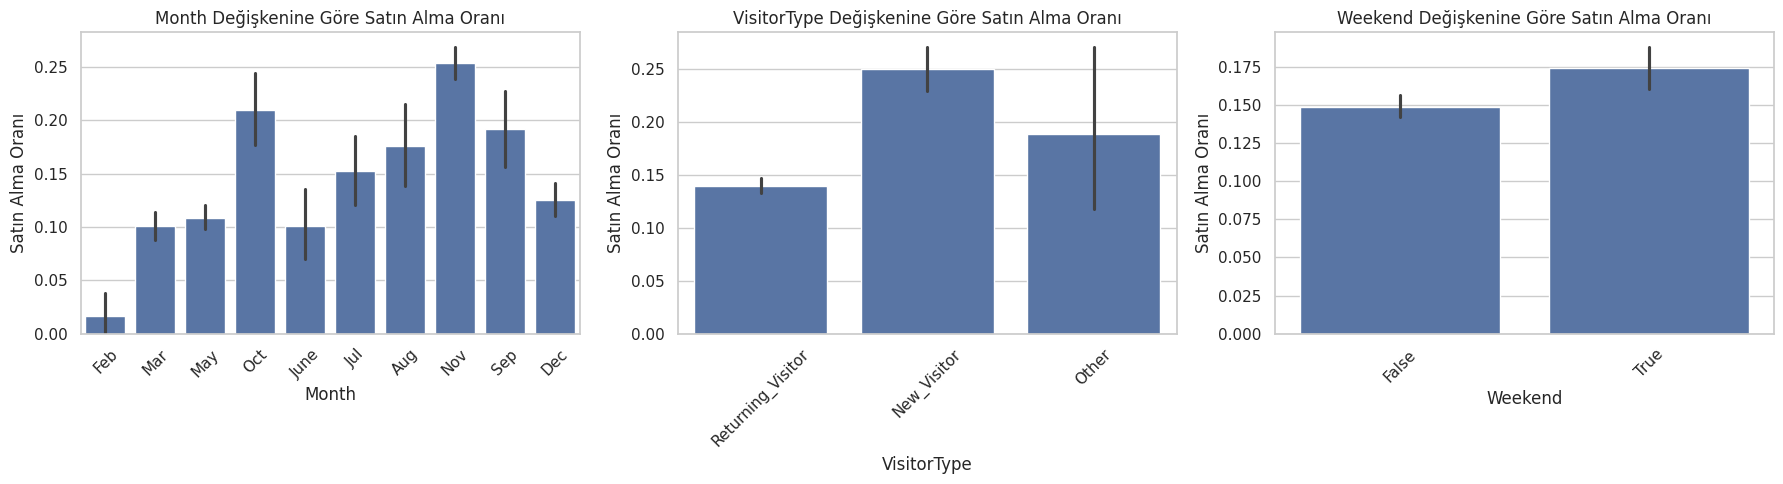

In [8]:
cat_features = ['Month', 'VisitorType', 'Weekend']

plt.figure(figsize=(18, 5))

for i, feature in enumerate(cat_features, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=feature, y='Revenue', data=df, estimator=lambda x: sum(x)/len(x))
    plt.title(f"{feature} Değişkenine Göre Satın Alma Oranı")
    plt.ylabel("Satın Alma Oranı")
    plt.xlabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

📊Yorumlar

>Month (Ay)
>
>- Kasım (Nov) ayında satın alma oranı bariz şekilde yüksek.
>- Muhtemelen kampanya veya indirim sezonları (Black Friday vs).
>
>VisitorType (Ziyaretçi Türü)
>
>- Returning Visitor (geri dönen ziyaretçi) grubunun satın alma oranı çok daha yüksek.
>- Marka sadakati veya önceki deneyimler etkili olabilir.
>
> Weekend (Hafta Sonu)
>
>- Hafta sonu yapılan ziyaretlerde satın alma oranı hafta içine göre biraz daha düşük.
>- Bu da ilginç bir bulgu; hafta içi alışveriş davranışı daha yoğun olabilir.


# Korelasyon ve Değişken Önemi Analizi

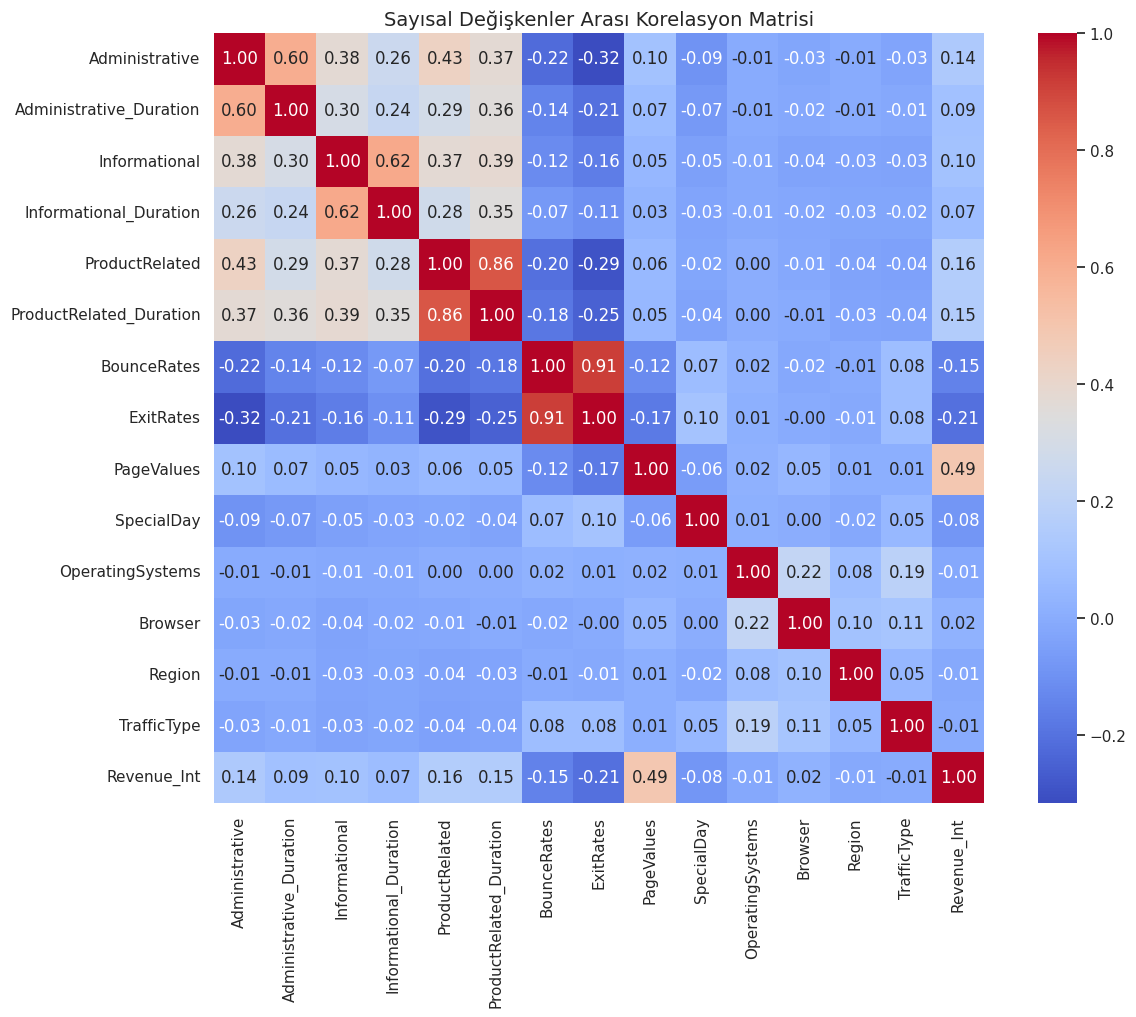

In [16]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numerical_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Sayısal Değişkenler Arası Korelasyon Matrisi", fontsize=14)
plt.show()

📊 Korelasyon Analizi – Öne Çıkan Bulgular

>Yüksek Korelasyonlu Değişkenler (Birbirine çok benzeyenler)
>- ProductRelated ↔ ProductRelated_Duration → 0.86 ; Yani: Bir kullanıcı ne kadar çok ürün sayfası ziyaret ederse, genellikle o kadar çok süre geçiriyor

>- Administrative ↔ Administrative_Duration → 0.60 ; Kullanıcı daha çok yönetimsel sayfa gezdikçe genellikle bu sayfalarda daha fazla süre geçiriyor, ancak korelasyon tam değil (r = 0.60 < 0.86)

>- BounceRates ↔ ExitRates → 0.91
>
>| Özellik         | BounceRates                | ExitRates                      |
>| --------------- | -------------------------- | ------------------------------ |
>| Nerede ölçülür? | İlk sayfa (siteye girişte) | Herhangi bir sayfa             |
>| Kapsamı         | Tüm oturumu temsil eder    | Belirli sayfaların çıkış oranı |
>| Tipik değer     | Daha düşük                 | Daha yaygın, daha geneldir     |


In [11]:
df['Revenue_Int'] = df['Revenue'].astype(int)

revenue_corr = df.corr(numeric_only=True)['Revenue_Int'].sort_values(ascending=False)

print("📈 Revenue ile korelasyonu en yüksek değişkenler:")
print(revenue_corr.drop('Revenue_Int').head(5))

print("\n📉 Revenue ile en negatif ilişkili değişkenler:")
print(revenue_corr.drop('Revenue_Int').tail(5))

📈 Revenue ile korelasyonu en yüksek değişkenler:
Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Name: Revenue_Int, dtype: float64

📉 Revenue ile en negatif ilişkili değişkenler:
Region             -0.011595
OperatingSystems   -0.014668
SpecialDay         -0.082305
BounceRates        -0.150673
ExitRates          -0.207071
Name: Revenue_Int, dtype: float64


En Yüksek Pozitif Korelasyonlar (Satın alma ile doğru orantılı)

| Değişken                  | Korelasyon (r) | Türkçesi                              |
| ------------------------- | -------------- | ------------------------------------- |
| `PageValues`              | **0.4926**     | Sayfa değeri – satın alma potansiyeli |
| `ProductRelated`          | 0.1582         | Ürün sayfası gezme sayısı             |
| `ProductRelated_Duration` | 0.1537         | Ürün sayfalarında geçirilen süre      |
| `Administrative`          | 0.1383         | Yönetimsel sayfa sayısı               |


En Negatif Korelasyonlar (Satın alma ile ters orantılı)

| Değişken           | Korelasyon (r) | Türkçesi                          |
| ------------------ | -------------- | --------------------------------- |
| `ExitRates`        | **-0.2072**    | Sayfadan çıkma oranı              |
| `BounceRates`      | -0.1662        | Hemen çıkma oranı                 |
| `SpecialDay`       | -0.0882        | Özel güne yakınlık                |
| `OperatingSystems` | -0.0466        | İşletim sistemi (kodlanmış değer) |
| `Region`           | -0.0153        | Kullanıcının bulunduğu bölge      |


# Lojistik Regresyon ile Satın Alma Tahmini

In [12]:
df['Revenue_Int'] = df['Revenue'].astype(int)
y = df['Revenue_Int']

selected_features = [
    'PageValues', 'BounceRates', 'ExitRates',
    'ProductRelated', 'ProductRelated_Duration',
    'Administrative', 'Month', 'VisitorType', 'Weekend'
]

X = pd.get_dummies(df[selected_features], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, report, conf_matrix

(0.8778048121113815,
 '              precision    recall  f1-score   support\n\n           0       0.89      0.97      0.93      3127\n           1       0.72      0.35      0.47       572\n\n    accuracy                           0.88      3699\n   macro avg       0.80      0.66      0.70      3699\nweighted avg       0.86      0.88      0.86      3699\n',
 array([[3048,   79],
        [ 373,  199]]))

### Lojistik Regresyon Sonuçları

| Metrik                  | Değer                                                                |
| ----------------------- | -------------------------------------------------------------------- |
| **Doğruluk (Accuracy)** | **%87.78**                                                           |
| **Precision (0 için)**  | %89 (Satın alma yapmadı diyenlerin %89’u doğru tahmin edildi)        |
| **Recall (1 için)**     | %35 (Gerçekten satın alanların sadece %35’i doğru tespit edilebildi) |
| **F1-Score (1 için)**   | %47 (Satın alanlar için genel başarı)                                |
| **Destek (Support)**    | 3127 (0), 572 (1) – Test setinde 572 kişi alışveriş yaptı            |


Yorumlar ve Değerlendirme

>- Model satın alma yapmayanları çok iyi tahmin ediyor (recall: %97)
>
>- Ancak satın alma yapanları zayıf yakalıyor (recall: %35)
>
>- Bu durumun temel nedeni: Veri dengesizliği → Revenue=True oranı sadece %15

# Dengelenmiş Lojistik Regresyon

In [14]:
balanced_model = LogisticRegression(class_weight='balanced', max_iter=1000)
balanced_model.fit(X_train, y_train)

y_pred_bal = balanced_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy_bal = accuracy_score(y_test, y_pred_bal)
report_bal = classification_report(y_test, y_pred_bal)
conf_matrix_bal = confusion_matrix(y_test, y_pred_bal)

print("✅ Dengelenmiş Model - Doğruluk Oranı:", round(accuracy_bal * 100, 2), "%")
print("\n📄 Sınıflandırma Raporu:\n", report_bal)
print("\n🧮 Karışıklık Matrisi:\n", conf_matrix_bal)

✅ Dengelenmiş Model - Doğruluk Oranı: 86.24 %

📄 Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92      3127
           1       0.54      0.75      0.63       572

    accuracy                           0.86      3699
   macro avg       0.75      0.82      0.77      3699
weighted avg       0.89      0.86      0.87      3699


🧮 Karışıklık Matrisi:
 [[2759  368]
 [ 141  431]]


### Dengelenmiş Lojistik Regresyon Sonuçları

| Metrik                      | Önceki Model | Yeni Model (`balanced`) |
| --------------------------- | ------------ | ----------------------- |
| **Doğruluk (Accuracy)**     | %87.78       | **%86.24**              |
| **Recall (Revenue = 1)**    | %35          | **%75** 🔥              |
| **Precision (Revenue = 1)** | %72          | %54                     |
| **F1-score (Revenue = 1)**  | %47          | **%63** ✅               |

Karışıklık Matrisi Yorumu

| Tahmin / Gerçek | 0 (Alışveriş Yok)   | 1 (Alışveriş Var)        |
| --------------- | ------------------- | ------------------------ |
| **Tahmin: 0**   | 2759 (doğru)        | 141 (kaçan satın alma) ❌ |
| **Tahmin: 1**   | 368 (yanlış alarm)❗ | 431 (doğru tespit) ✅     |



Yorum:

>- Model artık satın alma yapanları çok daha başarılı şekilde yakalıyor.
>
>- %75 recall, e-ticaret kampanyaları veya müşteri davranışı analizi gibi uygulamalar için çok daha anlamlı bir başarı.
>
>- Küçük bir doğruluk kaybı (%87.8 → %86.2) var ama hedef sınıfı tanıma başarısı önemli ölçüde artmış.

# Model Karşılaştırma Özeti (Tablo)

İki lojistik regresyon modelini performans metrikleri açısından karşılaştırılması ;

| Metrik                    | **Standart Model** | **Dengelenmiş Model** |
| ------------------------- | ------------------ | --------------------- |
| **Doğruluk (Accuracy)**   | %87.78             | %86.24                |
| **Precision (Revenue=1)** | %72                | %54                   |
| **Recall (Revenue=1)**    | %35                | **%75** ✅             |
| **F1-Score (Revenue=1)**  | %47                | **%63** ✅             |

🔍 Yorum:
>
>- class_weight='balanced' kullanımı, hedef sınıf olan satın alma yapan kullanıcıları çok daha başarılı şekilde tahmin etmeyi sağladı.
>
>- Bu tür veri dengesizliklerinde doğruluk yerine f1-score ve recall metrikleri önceliklidir.

# Proje Sonuçları ve Yorumlar


Proje Özeti;

- Bu çalışmada, e-ticaret kullanıcı davranışlarını temsil eden clickstream verisi üzerinden kullanıcıların satın alma davranışlarını tahmin etmek amaçlanmıştır. Veride toplam 12.330 oturum, 18 değişken ve Revenue (satın alma durumu) hedef değişkeni yer almaktadır.

Öne Çıkan Bulgular;

- Satın alma yapan kullanıcı oranı sadece %15.5 → Veri ciddi şekilde dengesiz

En belirleyici değişkenler:

- PageValues (sayfa değeri)

- ProductRelated_Duration (ürünle geçirilen süre)

- BounceRates (hemen çıkma oranı)

Satın alma yapan kullanıcılar:

- Ürün sayfalarında daha çok vakit geçiriyor

- Sayfa değeri yüksek sayfalarda dolaşıyor

- Geri dönen (returning) ziyaretçiler satın almaya daha meyilli

Model Sonuçları;

- Standart lojistik regresyon, satın alma yapmayanları çok iyi tahmin etti ancak alışveriş yapanları %35 oranında tanıyabildi.

- Dengelenmiş model, alışveriş yapanları %75 oranında tanıdı ve genel doğruluk %86.2 oldu.

- En dengeli performans dengelenmiş modelde gözlendi.

Öneriler;

- E-ticaret siteleri, kullanıcıların sayfa değeri ve ürünle etkileşim süresini artırarak satın alma oranlarını yükseltebilir.

- Returning Visitor’(Geri dönen müşteri)lar hedeflenerek yeniden pazarlama (remarketing) stratejileri uygulanabilir.

- Makine öğrenmesi uygulamaları gerçek zamanlı öneri sistemlerinde kullanılabilir.